## Binary Classificaiton

### Feature Selection

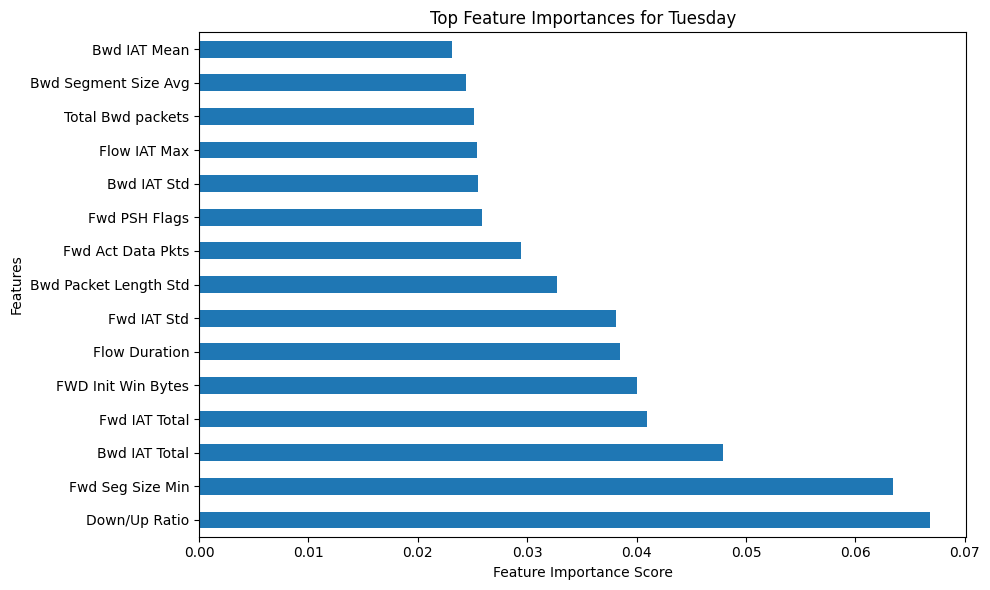

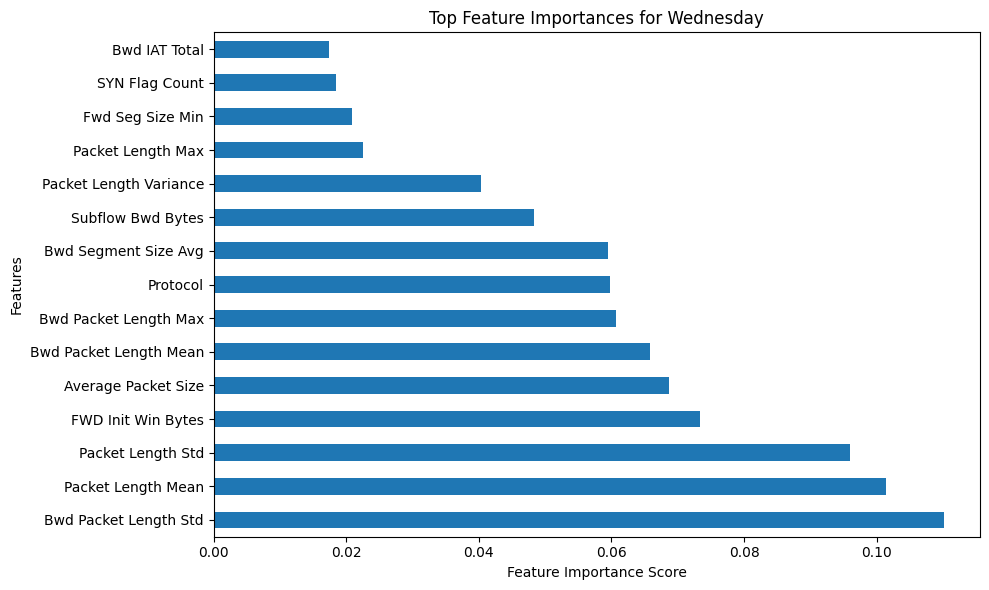

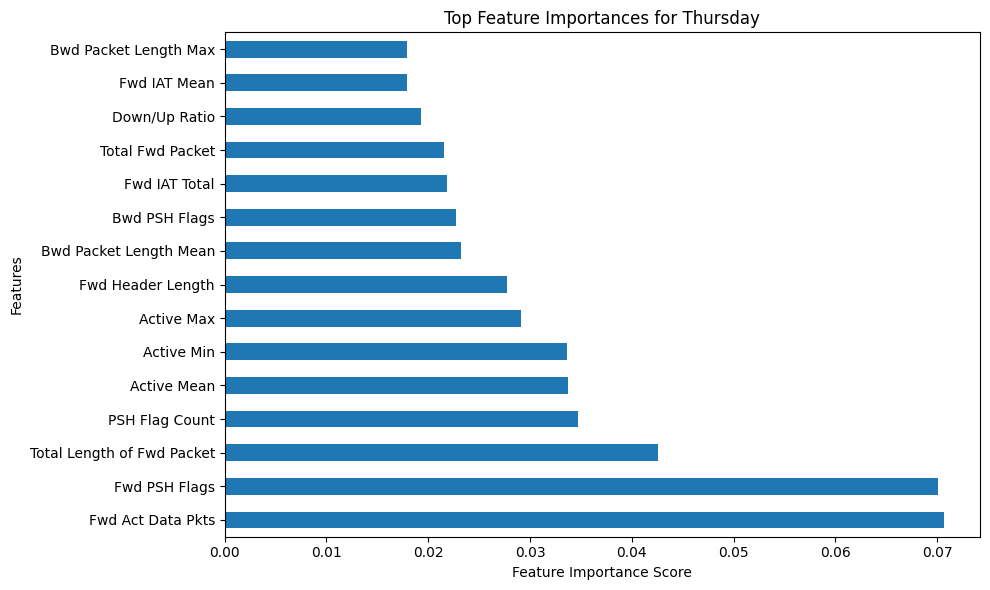

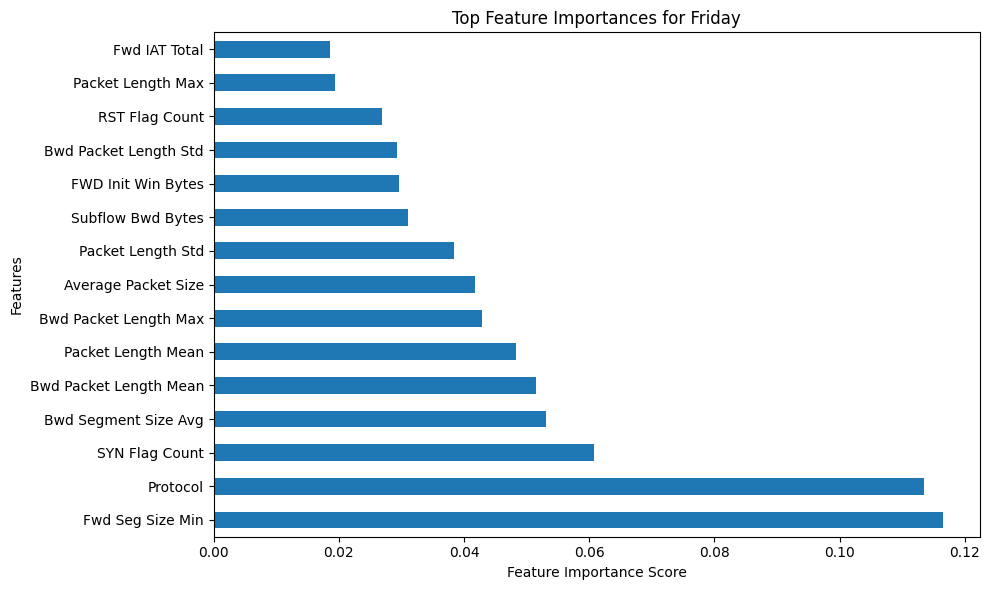

Top features for Tuesday:
['Down/Up Ratio', 'Fwd Seg Size Min', 'Bwd IAT Total', 'Fwd IAT Total', 'FWD Init Win Bytes', 'Flow Duration', 'Fwd IAT Std', 'Bwd Packet Length Std', 'Fwd Act Data Pkts', 'Fwd PSH Flags', 'Bwd IAT Std', 'Flow IAT Max', 'Total Bwd packets', 'Bwd Segment Size Avg', 'Bwd IAT Mean']

Top features for Wednesday:
['Bwd Packet Length Std', 'Packet Length Mean', 'Packet Length Std', 'FWD Init Win Bytes', 'Average Packet Size', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Protocol', 'Bwd Segment Size Avg', 'Subflow Bwd Bytes', 'Packet Length Variance', 'Packet Length Max', 'Fwd Seg Size Min', 'SYN Flag Count', 'Bwd IAT Total']

Top features for Thursday:
['Fwd Act Data Pkts', 'Fwd PSH Flags', 'Total Length of Fwd Packet', 'PSH Flag Count', 'Active Mean', 'Active Min', 'Active Max', 'Fwd Header Length', 'Bwd Packet Length Mean', 'Bwd PSH Flags', 'Fwd IAT Total', 'Total Fwd Packet', 'Down/Up Ratio', 'Fwd IAT Mean', 'Bwd Packet Length Max']

Top features for Frida

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import json

PATH = "datasets"

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory
output_path = PATH + '/feat_sel/binary-class'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to preprocess data and return top features
def process_data(day):
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # ... [Data preprocessing steps] ...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    data.rename(columns={'Label': 'label'}, inplace=True)
    data['binary_label'] = data['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    
    # print(data.columns)
    
    drop_columns = [
        "Flow ID", "Src IP" , "Src Port", "Dst IP", 
        "Dst Port", 
        # "Protocol", 
        "Timestamp", 
        "label"
    ]
    data.drop(columns=drop_columns, inplace=True)
    
    X = data.drop('binary_label', axis=1)
    y = data['binary_label']

    # Build the model
    model = ExtraTreesClassifier()
    model.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select top N features
    top_features = feat_importances.nlargest(15).index.tolist()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title(f'Top Feature Importances for {day}')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{day}_feature_importances.png"))  # Save the figure
    # plt.close()  # Close the plot to prevent it from displaying inline if using a notebook
    plt.show()
    
    return top_features

# Dictionary to store top features for each day
top_features_per_day = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    top_features_per_day[day] = process_data(day)

# Print out the top features for each day
for day, features in top_features_per_day.items():
    print(f"Top features for {day}:\n{features}\n")

json_file_path = os.path.join(output_path, 'top_features_per_day.json')
with open(json_file_path, 'w') as json_file:
    json.dump(top_features_per_day, json_file, indent=4)

print(f"Top features for each day have been saved to {json_file_path}")

### Classification

In [2]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Initialize a dictionary to store the metrics for each model
model_metrics = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # Preprocessing steps identical to the feature selection stage...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    data['binary_label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    X = data[top_features_per_day[day]]
    y = data['binary_label']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    # Train and evaluate each classifier
    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute the metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        # Store metrics
        if day not in model_metrics:
            model_metrics[day] = {}
        model_metrics[day][model_name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i, j): model_metrics[i][j]
                                     for i in model_metrics.keys()
                                     for j in model_metrics[i].keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# print(f"Model performance metrics have been saved to {metrics_json_path}")

                        Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday   DecisionTree   0.996174  0.998562  0.999886  0.997367  0.999239
          RandomForest   1.000000  0.999521  0.999990  0.999760  0.999760
          NaiveBayes     0.946959  0.992809  0.998644  0.969342  0.995791
Wednesday DecisionTree   0.999534  0.999884  0.999796  0.999709  0.999816
          RandomForest   0.999884  0.999690  0.999851  0.999787  0.999813
          NaiveBayes     0.920835  0.964860  0.958681  0.942334  0.960108
Thursday  DecisionTree   0.948276  0.820896  0.999861  0.880000  0.910434
          RandomForest   1.000000  0.865672  0.999917  0.928000  0.932836
          NaiveBayes     0.037064  0.761194  0.987590  0.070686  0.874462
Friday    DecisionTree   0.999438  0.999856  0.999670  0.999647  0.999682
          RandomForest   0.999490  0.999882  0.999707  0.999686  0.999718
          NaiveBayes     0.937509  0.689627  0.833681  0.794686  0.824696


## Multi-class Classification

### Feature Selection

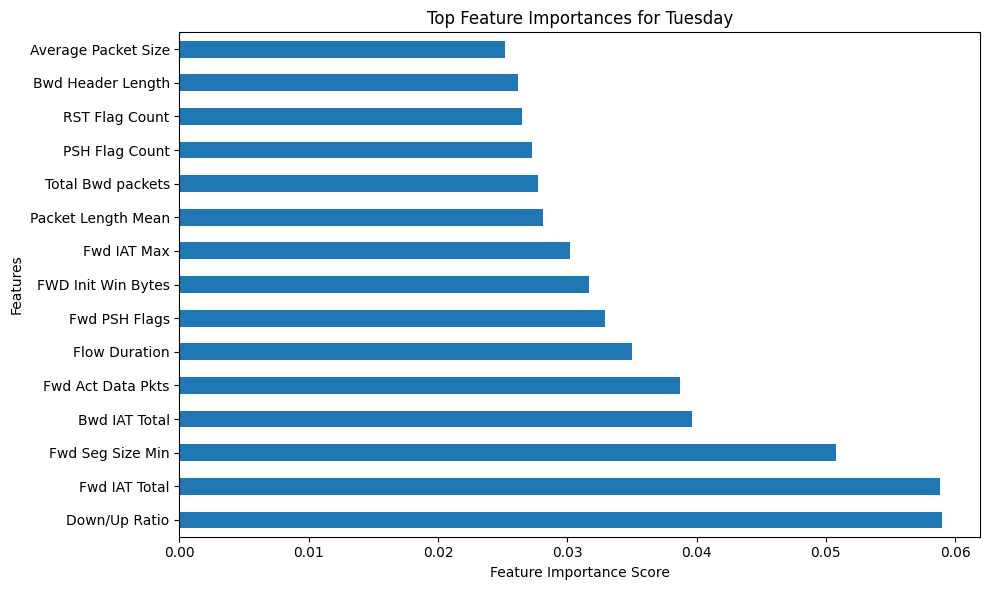

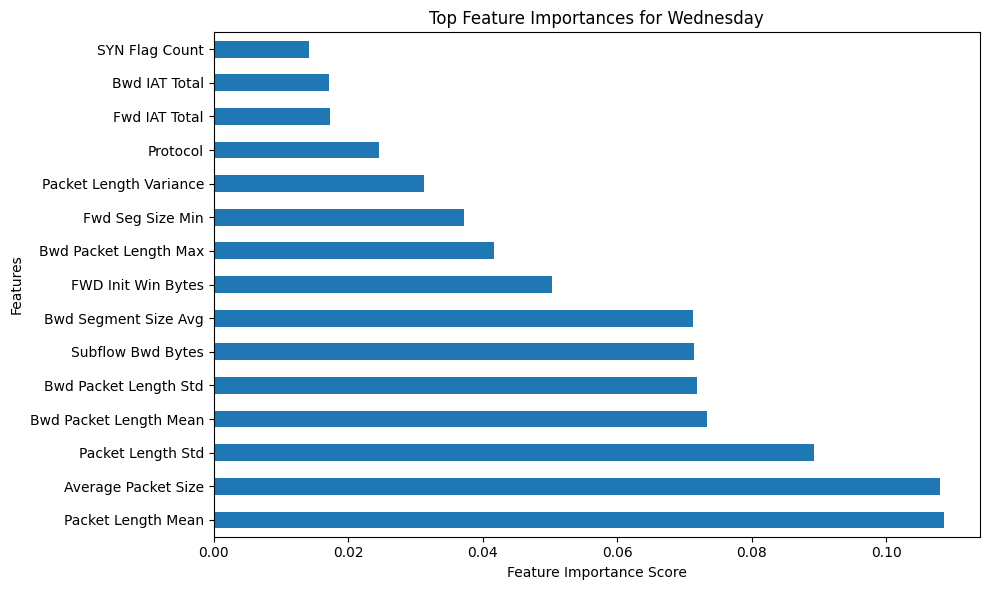

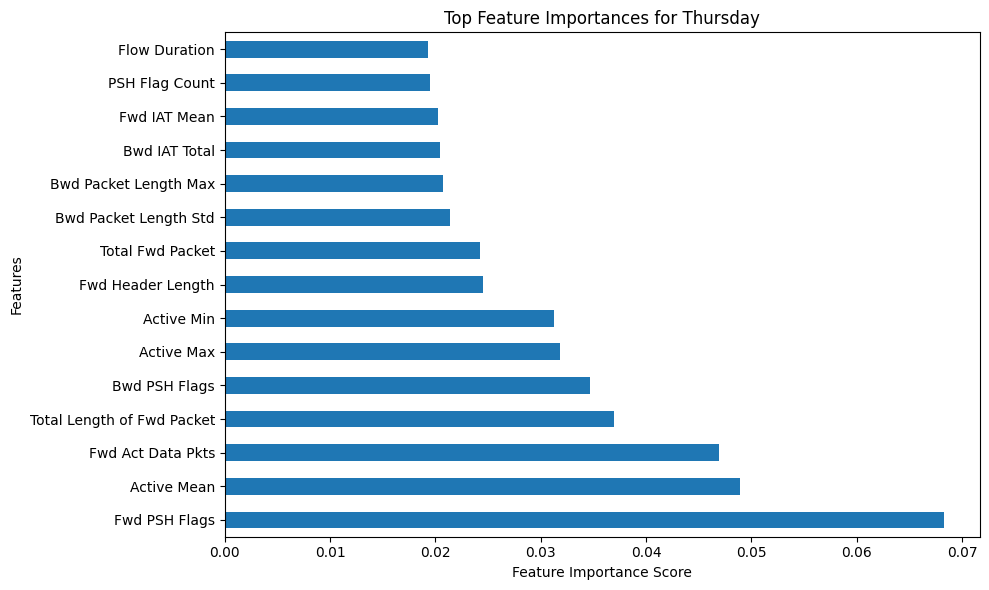

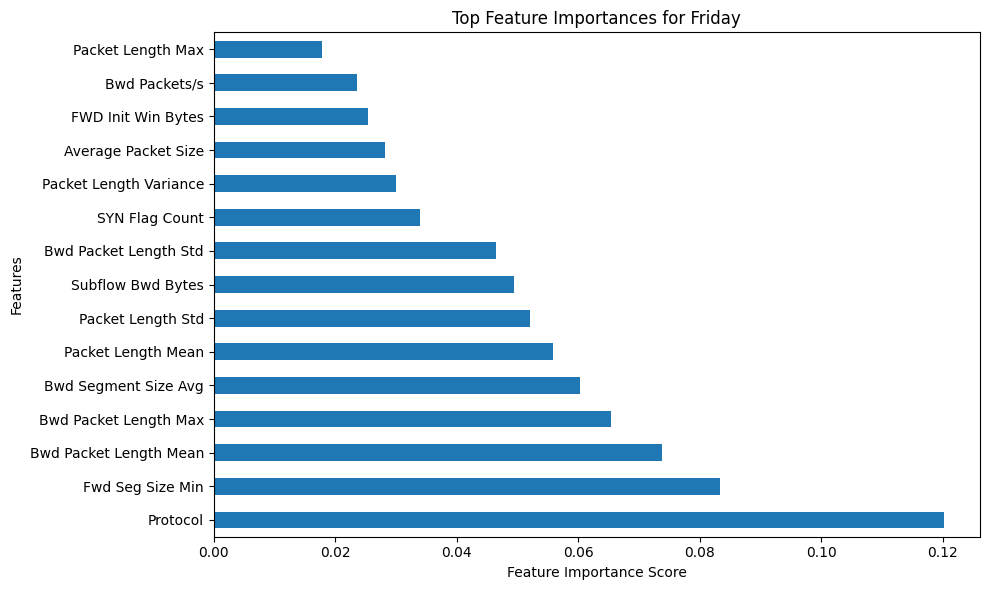

Top features for Tuesday:
['Down/Up Ratio', 'Fwd IAT Total', 'Fwd Seg Size Min', 'Bwd IAT Total', 'Fwd Act Data Pkts', 'Flow Duration', 'Fwd PSH Flags', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Packet Length Mean', 'Total Bwd packets', 'PSH Flag Count', 'RST Flag Count', 'Bwd Header Length', 'Average Packet Size']

Top features for Wednesday:
['Packet Length Mean', 'Average Packet Size', 'Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Subflow Bwd Bytes', 'Bwd Segment Size Avg', 'FWD Init Win Bytes', 'Bwd Packet Length Max', 'Fwd Seg Size Min', 'Packet Length Variance', 'Protocol', 'Fwd IAT Total', 'Bwd IAT Total', 'SYN Flag Count']

Top features for Thursday:
['Fwd PSH Flags', 'Active Mean', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd PSH Flags', 'Active Max', 'Active Min', 'Fwd Header Length', 'Total Fwd Packet', 'Bwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean', 'PSH Flag Count', 'Flow Duration']

Top features for Frid

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import json

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory for multi-class classification
output_path = PATH + '/feat_sel/multi-class'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to preprocess data and return top features
def process_data(day):
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # ... [Data preprocessing steps] ...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    data.rename(columns={'Label': 'label'}, inplace=True)
    
    # For multi-class classification, use the 'label' column directly
    # No need for a binary label
    drop_columns = [
        "Flow ID", "Src IP" , "Src Port", "Dst IP", 
        "Dst Port", 
        # "Protocol", 
        "Timestamp"
    ]
    data.drop(columns=drop_columns, inplace=True)
    
    X = data.drop('label', axis=1)
    y = data['label']  # This will now have multiple classes

    # Build the model
    model = ExtraTreesClassifier()
    model.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select top N features
    top_features = feat_importances.nlargest(15).index.tolist()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title(f'Top Feature Importances for {day}')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{day}_feature_importances.png"))  # Save the figure
    plt.show()
    
    return top_features

# Dictionary to store top features for each day
top_features_per_day = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    top_features_per_day[day] = process_data(day)

# Print out the top features for each day
for day, features in top_features_per_day.items():
    print(f"Top features for {day}:\n{features}\n")

# Save the top features for each day into a JSON file
json_file_path = os.path.join(output_path, 'top_features_per_day_multi_class.json')
with open(json_file_path, 'w') as json_file:
    json.dump(top_features_per_day, json_file, indent=4)

print(f"Top features for each day have been saved to {json_file_path}")

### Classificaiton

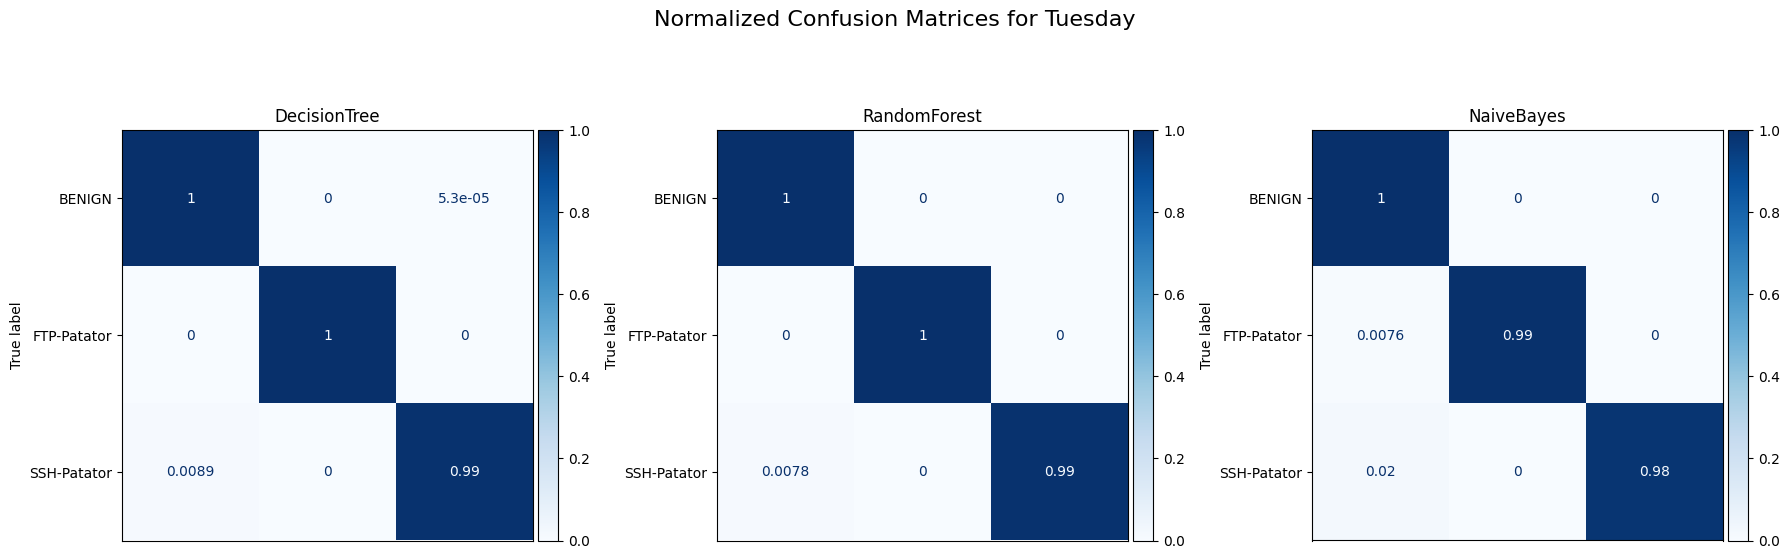

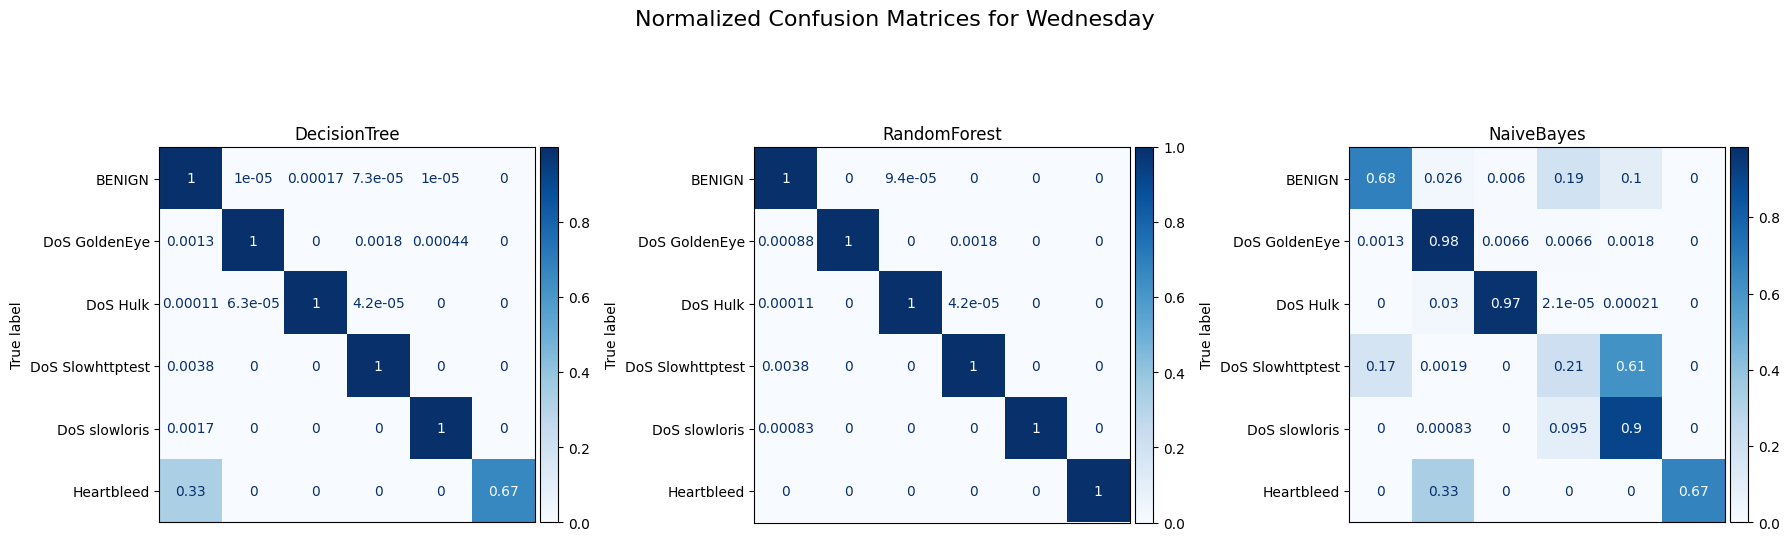

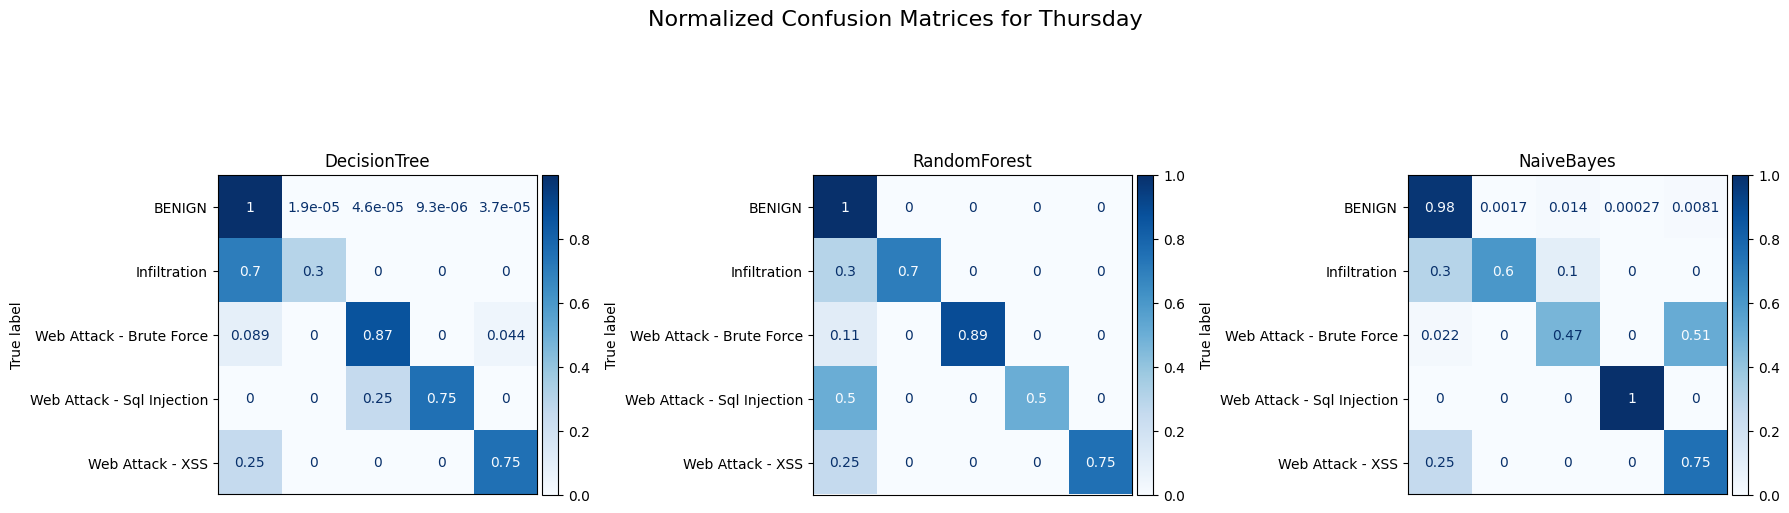

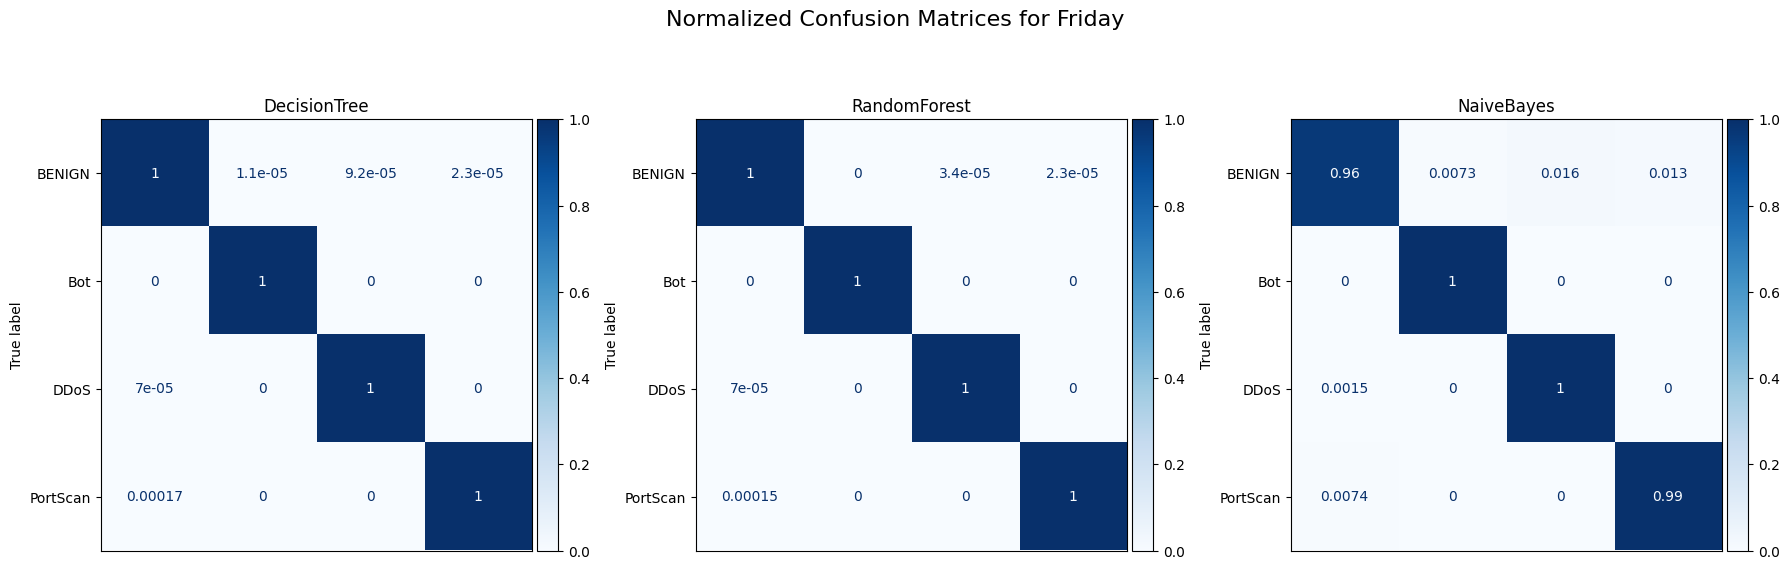

                        Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday   DecisionTree   0.999865  0.999865  0.999865  0.999865  0.998056
          RandomForest   0.999928  0.999928  0.999928  0.999927  0.999758
          NaiveBayes     0.999721  0.999720  0.999720  0.999719  0.994333
Wednesday DecisionTree   0.999676  0.999674  0.999674  0.999674  0.999729
          RandomForest   0.999831  0.999830  0.999830  0.999830  0.999986
          NaiveBayes     0.974295  0.777790  0.777790  0.851050  0.995702
Thursday  DecisionTree   0.999741  0.999741  0.999741  0.999734  0.902916
          RandomForest   0.999889  0.999889  0.999889  0.999881  0.984951
          NaiveBayes     0.999337  0.976226  0.976226  0.987490  0.965879
Friday    DecisionTree   0.999872  0.999872  0.999872  0.999872  0.999906
          RandomForest   0.999915  0.999915  0.999915  0.999915  0.999973
          NaiveBayes     0.981834  0.978551  0.978551  0.979659  0.989006


In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, accuracy_score,
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the selected features for multi-class classification
# with open(json_file_path, 'r') as json_file:
#     top_features_per_day = json.load(json_file)

# Initialize a dictionary to store the metrics for each model
model_metrics = {}
confusion_matrices = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # Preprocessing steps...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    X = data[top_features_per_day[day]]
    y = data['Label']  # Use original labels for multi-class classification
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    # Create a figure with subplots for each model's confusion matrix
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle(f'Normalized Confusion Matrices for {day}', fontsize=16)
    
    # Train and evaluate each classifier
    for ax, (model_name, model) in zip(axes.flatten(), classifiers.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute the metrics with multi-class considerations
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
        
        # Compute and plot the normalized confusion matrix
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp.plot(cmap='Blues', ax=ax)
        ax.title.set_text(f'{model_name}')

        # Remove the original colorbar generated by ConfusionMatrixDisplay
        if disp.im_.colorbar:
            disp.im_.colorbar.remove()
        
        # Create an axis for the colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(disp.im_, cax=cax)
        
        # Remove x-axis labels and ticks
        disp.ax_.set_xlabel('')
        disp.ax_.set_xticks([])
        # Remove y-axis labels and ticks if desired
        # disp.ax_.set_ylabel('')
        # disp.ax_.set_yticks([])
        
        # Store metrics
        if day not in model_metrics:
            model_metrics[day] = {}
        model_metrics[day][model_name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }
        
        # Store the computed confusion matrix
        confusion_matrices[(day, model_name)] = cm

        # Now create an individual figure for the current classifier
        fig_individual, ax_individual = plt.subplots(figsize=(6, 6))
        disp_individual = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp_individual.plot(cmap='Blues', ax=ax_individual)
        ax_individual.title.set_text(f'{model_name} Confusion Matrix for {day}')
        # ... [code to adjust the individual plot as needed] ...

        # Remove x-axis labels and ticks
        disp_individual.ax_.set_xlabel('')
        disp_individual.ax_.set_xticks([])
        
        # Remove the original colorbar generated by ConfusionMatrixDisplay
        if disp_individual.im_.colorbar:
            disp_individual.im_.colorbar.remove()
        
        # Create an axis for the colorbar on the individual plot
        divider_individual = make_axes_locatable(ax_individual)
        cax_individual = divider_individual.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(disp_individual.im_, cax=cax_individual)
        
        # Save the individual confusion matrix plot for the current model
        fig_individual.tight_layout()
        fig_individual.savefig(os.path.join(output_path, f"{day}_{model_name}_confusion_matrix.png"))
        plt.close(fig_individual)  # Close the individual figure to free memory
    
    # Adjust layout and add a single legend
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    plt.close(fig)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i, j): model_metrics[i][j]
                                     for i in model_metrics.keys()
                                     for j in model_metrics[i].keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics_multi_class.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# Save the confusion matrices to a JSON file
cm_json_path = os.path.join(output_path, 'confusion_matrices_multi_class.json')
with open(cm_json_path, 'w') as cm_file:
    # We convert the arrays into lists for JSON serialization
    json.dump({str(k): v.tolist() for k, v in confusion_matrices.items()}, cm_file, indent=4)

# print(f"Model performance metrics and confusion matrices for multi-class classification have been saved.")